# Master pipeline notebook


### This notebook follows the ML pipeline process of gathering data, performing analysis, modelling and evaluation


The process involves: 
1. Data gathering and pre-processing
2. Data analysis
3. Feature engineering 
4. Data transformation
5. LSTM Modelling 
6. Evaluation


_Note: Run the notebook from start to end._


In [1]:
import pandas as pd
from data import gatherData
import plotly.graph_objects as go
from pre_process_data import processData
from feature import engineerFeaturesForTraining, splitData
from transform import transformData
from utils import load_config_file, save_as_pickle
from train import train
import plotly.figure_factory as ff
import torch
from LSTM_model import LSTM
from inference import makeInference
from evaluation import evaluateModellingResults
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

import random

In [2]:
config = load_config_file("config.yml")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Data gathering and pre-processing

- Gather the data 
- Pre process it:
    - Merge columns from races_df and results_df
    - Add columns from pit_stop_df
    - Work on the outliers in the data
    - remove race_ids with less that 8 data points


In [3]:
gather_data_obj = gatherData(config=config)

In [4]:
(
    lap_times_df,
    pit_stops_df,
    qualifying_df,
    races_df,
    results_df,
    sprint_results_df,
    status_df,
) = gather_data_obj.load_data()

In [5]:
pre_process_obj = processData(config=config)

master_lap_times_df = pre_process_obj.create_initial_dataset(
    lap_times_df=lap_times_df, races_df=races_df, results_df=results_df
)
master_lap_times_df

,raceId,driverId,lap,position,milliseconds,year,round,circuitId,name,date,number,statusId
0,841,20,1,1,98109,2011,1,1,Australian Grand Prix,2011-03-27,1,1
1,841,20,2,1,93006,2011,1,1,Australian Grand Prix,2011-03-27,1,1
2,841,20,3,1,92713,2011,1,1,Australian Grand Prix,2011-03-27,1,1
3,841,20,4,1,92803,2011,1,1,Australian Grand Prix,2011-03-27,1,1
4,841,20,5,1,92342,2011,1,1,Australian Grand Prix,2011-03-27,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
551737,1110,817,40,17,114361,2023,12,13,Belgian Grand Prix,2023-07-30,3,1
551738,1110,817,41,17,113367,2023,12,13,Belgian Grand Prix,2023-07-30,3,1
551739,1110,817,42,16,115247,2023,12,13,Belgian Grand Prix,2023-07-30,3,1
551740,1110,817,43,16,112115,2023,12,13,Belgian Grand Prix,2023-07-30,3,1


In [6]:
# check for nans in the data
master_lap_times_df.isna().any()

raceId          False
driverId        False
lap             False
position        False
milliseconds    False
year            False
round           False
circuitId       False
name            False
date            False
number          False
statusId        False
dtype: bool

In [7]:
driver_id = 20
race_id = 841

lap_times_selected_driver_race = master_lap_times_df[
    (master_lap_times_df["raceId"] == race_id)
    & (master_lap_times_df["driverId"] == driver_id)
]

In [8]:
## Lap times and pit stops

fig = go.Figure()

gp_name = master_lap_times_df[master_lap_times_df["raceId"] == race_id][
    "name"
].unique()[0]

fig.add_trace(
    go.Scatter(
        x=lap_times_selected_driver_race["lap"],
        y=lap_times_selected_driver_race["milliseconds"],
        mode="lines+markers",
        name="Lap times in milliseconds",
    )
)

fig.update_layout(
    title=f"Laptimes by each lap for GP: {gp_name}",
    xaxis_title="Lap number",
    yaxis_title="Total lap time (ms)",
)

- Two outliers in the data 
- this is mainly the pit stops that happen in between the race

#### Add pit stop data

In [9]:
master_laptimes_pitstop_df = pre_process_obj.add_pitstop_data(
    master_laptime_data=master_lap_times_df, pit_stop_data=pit_stops_df
)
master_laptimes_pitstop_df

,raceId,driverId,lap,position,milliseconds,year,round,circuitId,name,date,number,statusId,pitStopMilliseconds,isPitStop
0,841,20,1,1,98109,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
1,841,20,2,1,93006,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
2,841,20,3,1,92713,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
3,841,20,4,1,92803,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
4,841,20,5,1,92342,2011,1,1,Australian Grand Prix,2011-03-27,1,1,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551737,1110,817,40,17,114361,2023,12,13,Belgian Grand Prix,2023-07-30,3,1,0.0,False
551738,1110,817,41,17,113367,2023,12,13,Belgian Grand Prix,2023-07-30,3,1,0.0,False
551739,1110,817,42,16,115247,2023,12,13,Belgian Grand Prix,2023-07-30,3,1,0.0,False
551740,1110,817,43,16,112115,2023,12,13,Belgian Grand Prix,2023-07-30,3,1,0.0,False


In [10]:
driver_id = 20
lap_times_selected_driver = master_laptimes_pitstop_df[
    (master_laptimes_pitstop_df["driverId"] == driver_id)
]

In [11]:
fig = go.Figure()

# Add a box trace
fig.add_trace(
    go.Box(y=lap_times_selected_driver["milliseconds"], name="Lap times for Aus GP")
)

# Customize the layout
fig.update_layout(
    title="Box Plot for lap times in milliseconds",
    yaxis_title="Lap times (milliseconds)",
)

# Show the figure
fig.show()

#### replace outliers that have lap times more tha 500,000 ms by avg of lap times of that race id

In [12]:
master_lap_time_data = pre_process_obj.work_on_outliers(
    master_lap_time_data=lap_times_selected_driver
)

## Data Analysis

In [13]:
histvalues = [master_lap_time_data["milliseconds"]]
names = ["lap times"]

fig = ff.create_distplot(
    histvalues,
    names,
    bin_size=10000,
    show_rug=False,
    curve_type="kde",
    histnorm="probability",
)

fig.update_layout(
    title="density of lap times in all races for the driver: 20",
    xaxis_title="Lap times (milliseconds)",
    yaxis_title="density",
)


fig.show()

In [14]:
fig = go.Figure()

# Add a box trace
fig.add_trace(
    go.Box(y=master_lap_time_data["milliseconds"], name="Lap times for all GPs")
)

# Customize the layout
fig.update_layout(
    title="Box Plot for millisecond for all GPs",
    yaxis_title="Lap times (milliseconds)",
)

# Show the figure
fig.show()

In [15]:
fig = go.Figure()

circuit_id = 1

lap_times_selected_driver_circuit = master_lap_time_data[
    master_lap_time_data["circuitId"] == circuit_id
]
list_race_id = lap_times_selected_driver_circuit["raceId"].unique().tolist()

for race_id in list_race_id:

    lap_times_race = lap_times_selected_driver_circuit[
        lap_times_selected_driver_circuit["raceId"] == race_id
    ]

    fig.add_trace(
        go.Scatter(
            x=lap_times_race["lap"],
            y=lap_times_race["milliseconds"],
            mode="lines+markers",
            name=f"race id: {race_id}",
        )
    )
    condition = lap_times_race["isPitStop"]

    fig.add_trace(
        go.Scatter(
            x=lap_times_race.loc[condition, "lap"],
            y=lap_times_race.loc[condition, "milliseconds"],
            mode="markers",
            marker=dict(color="red", size=12, symbol="circle"),
            name=f"Pit stop race: {race_id}",
        )
    )

    fig.update_layout(
        title=f"Laptimes by each lap for circuit: {circuit_id}",
        xaxis_title="Lap number",
        yaxis_title="Total lap time",
    )
fig.show()

#### Normal race scenario
- RaceId: 841
    - Two pit stops time: lap times increased during those points
#### Outlier situation
- RaceId: 860
    - Two pit stops, but lap time were still grater than normal
    - why? - Red flag or yellow flag? other outside factors?

In [16]:
fig = go.Figure()

circuit_id = 12

lap_times_selected_driver_circuit = master_lap_time_data[
    master_lap_time_data["circuitId"] == circuit_id
]
list_race_id = lap_times_selected_driver_circuit["raceId"].unique().tolist()

for race_id in list_race_id:

    lap_times_race = lap_times_selected_driver_circuit[
        lap_times_selected_driver_circuit["raceId"] == race_id
    ]

    fig.add_trace(
        go.Scatter(
            x=lap_times_race["lap"],
            y=lap_times_race["milliseconds"],
            mode="lines+markers",
            name=f"race id: {race_id}",
        )
    )

    condition = lap_times_race["isPitStop"]

    fig.add_trace(
        go.Scatter(
            x=lap_times_race.loc[condition, "lap"],
            y=lap_times_race.loc[condition, "milliseconds"],
            mode="markers",
            marker=dict(color="red", size=10, symbol="circle"),
            name=f"Pit stop race: {race_id}",
        )
    )

    fig.update_layout(
        title=f"Laptimes by each lap for circuit: {circuit_id}",
        xaxis_title="Lap number",
        yaxis_title="Total lap time",
    )
fig.show()

#### Another situation:
- No pitstops in race_id: 345, missing data: need to add pitstops to these races:
    - first greater than average lap times would be regarded as pit stops 
- No data about the sudden increase in lap time
    - these points are also outliers, they can be regarded as red/yellow flags as the speed at these points reduces

#### Correlation Matrix

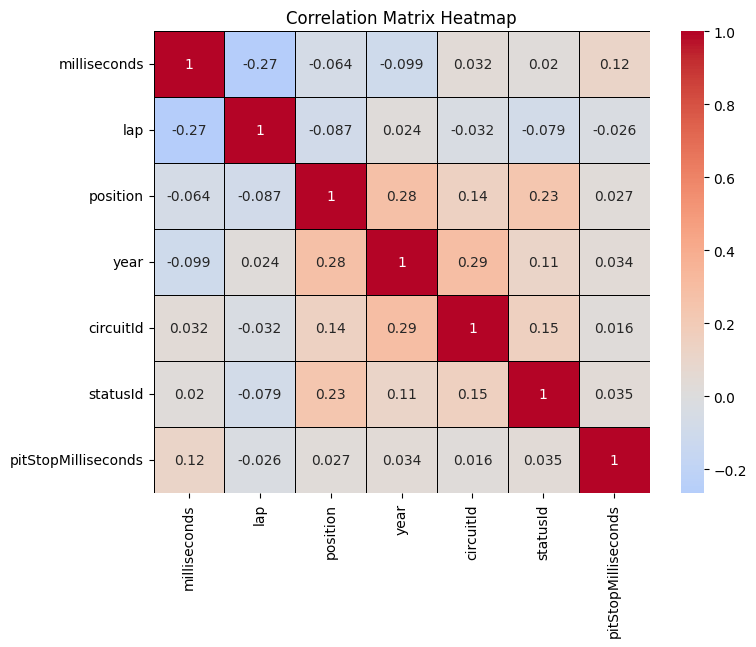

In [17]:
columns_for_corr = [
    "milliseconds",
    "lap",
    "position",
    "year",
    "circuitId",
    "statusId",
    "pitStopMilliseconds",
]

master_lap_time_data_corr_matrix = master_lap_time_data[columns_for_corr].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    master_lap_time_data_corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor="black",
)
plt.title("Correlation Matrix Heatmap")
plt.show()

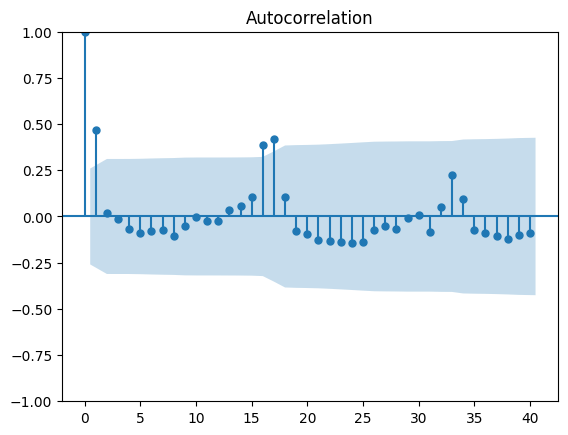

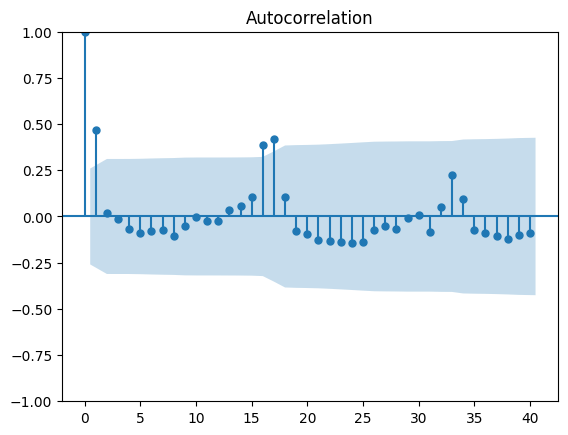

In [18]:
lap_times_race_848 = master_lap_time_data[master_lap_time_data["raceId"] == 848]
plot_acf(lap_times_race_848["milliseconds"], lags=40)

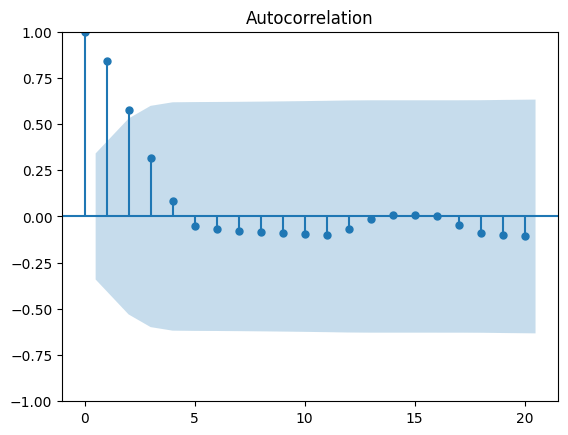

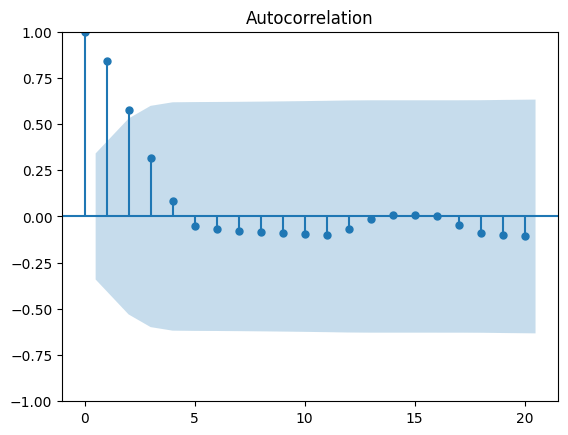

In [19]:
lap_times_race_867 = master_lap_time_data[master_lap_time_data["raceId"] == 867]
plot_acf(lap_times_race_867["milliseconds"], lags=20)

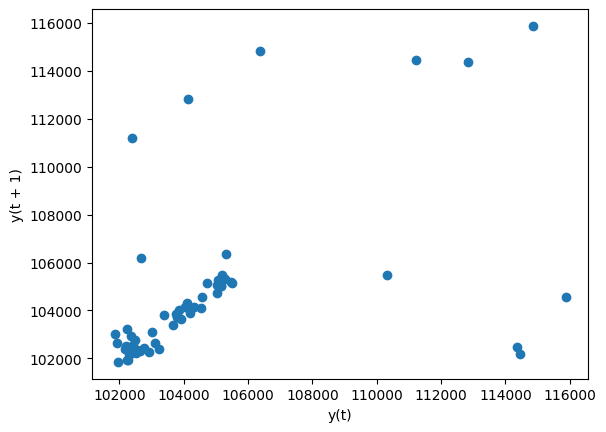

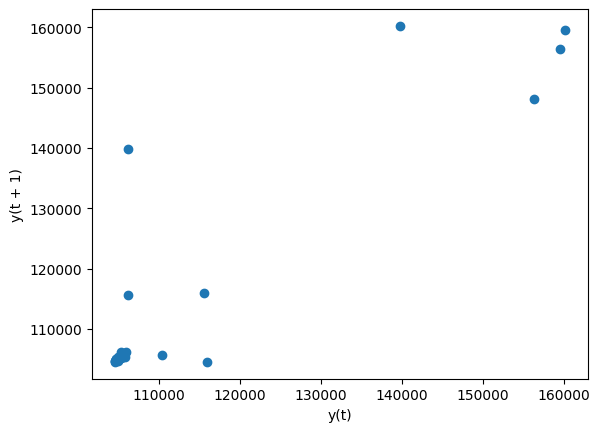

In [20]:
pd.plotting.lag_plot(lap_times_race_848["milliseconds"], lag=1)
plt.show()

pd.plotting.lag_plot(lap_times_race_867["milliseconds"], lag=1)
plt.show()

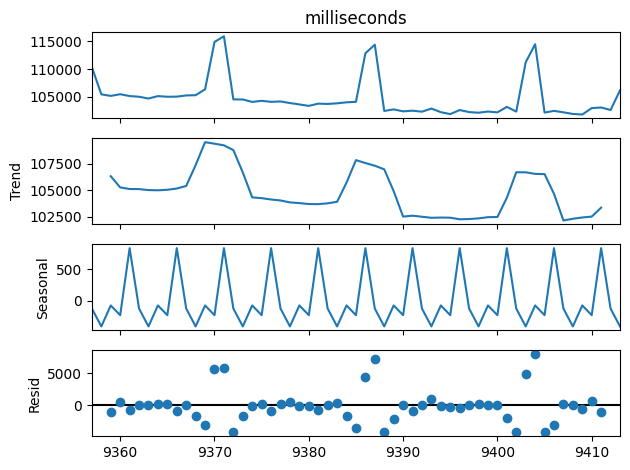

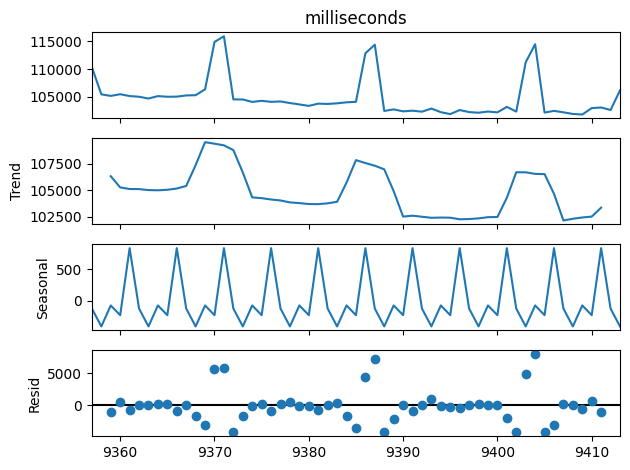

In [21]:
result = seasonal_decompose(
    lap_times_race_848["milliseconds"], model="additive", period=5
)
result.plot()

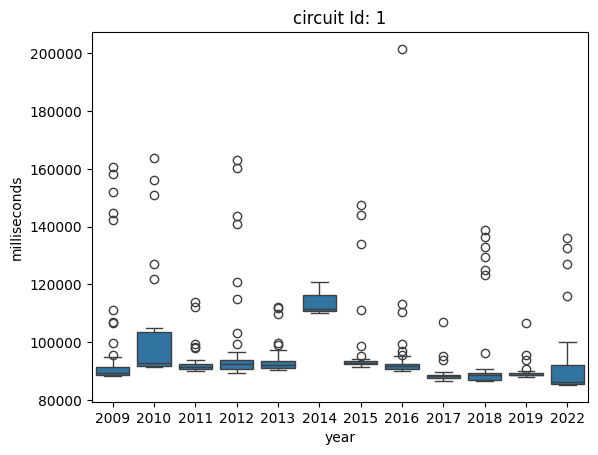

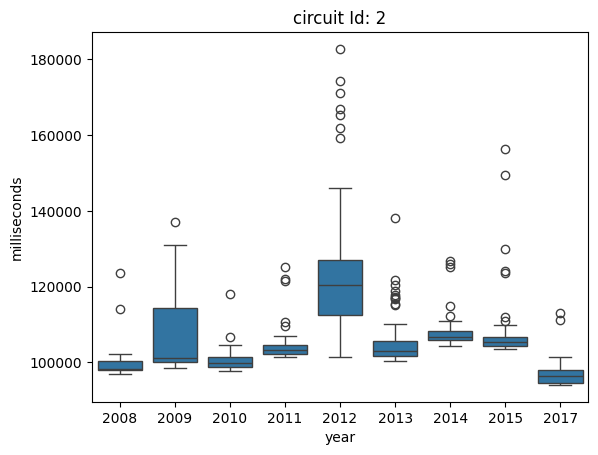

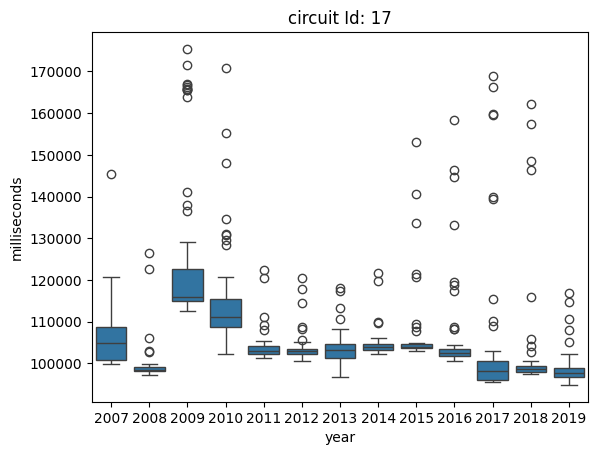

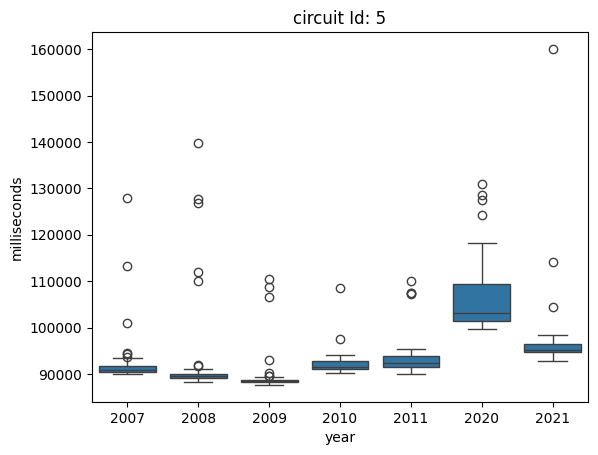

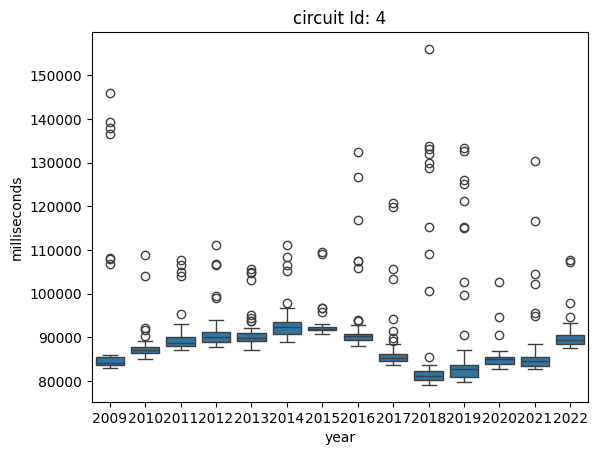

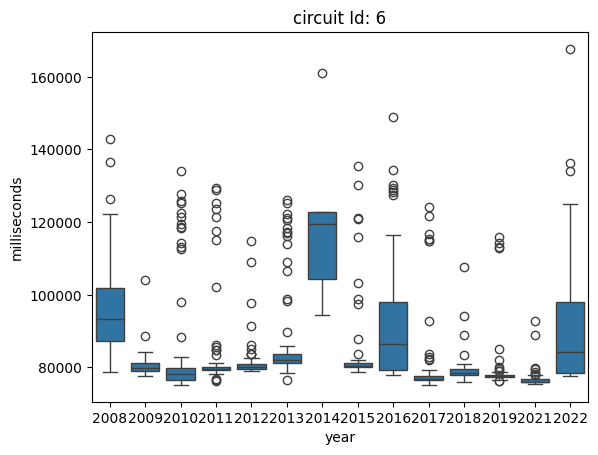

In [22]:
ls_circuit_id = [1, 2, 17, 5, 4, 6]

for c_id in ls_circuit_id:
    lap_times_circuit = master_lap_time_data[master_lap_time_data["circuitId"] == c_id]

    sns.boxplot(x="year", y="milliseconds", data=lap_times_circuit)
    plt.title(f"circuit Id: {c_id}")
    plt.show()

## Feature Engineering

- Add columns that can help in modelling
    - add date feature columns
    - add lagged features: previous_lap_time, previous_lap_position, previous_lap_number
    - one hot encode the categorical features

- New features that were added:
    - Pit stop indincator
    - race flag indicator
    - lap difference
    - is pit stop
    - lagged columns 
        - milliseconds
        - lap
        - position
        - pitStopMilliseconds
        - isPitStop
        - PitStopIndicator
        - lapDifference
        - isRaceFlag

In [23]:
results_df_by_driver = results_df[results_df["driverId"] == driver_id]
results_df_by_driver = results_df_by_driver.reset_index(drop=True)
engineer_data_obj = engineerFeaturesForTraining(config=config)


engineered_lap_times_df, encoder, encoder_columns = engineer_data_obj.engineer_data(
    lap_times_data=master_lap_time_data, results_df=results_df_by_driver
)

In [24]:
engineered_lap_times_df

,raceId,lap,position,milliseconds,year,isPitStop,pitStopMilliseconds,PitStopIndicator,isRaceFlag,lapDifference,...,circuitId_68,circuitId_69,circuitId_70,circuitId_71,circuitId_73,circuitId_75,circuitId_76,circuitId_77,circuitId_78,circuitId_79
1,1,2,2,91173.0,2009,0,0.0,0,0,-8474.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,2,89752.0,2009,0,0.0,0,0,-1421.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,4,2,88999.0,2009,0,0.0,0,0,-753.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,5,2,88849.0,2009,0,0.0,0,0,-150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,6,2,88424.0,2009,0,0.0,0,0,-425.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16394,1096,54,11,90931.0,2022,0,0.0,1,0,-125.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16395,1096,55,11,91304.0,2022,0,0.0,1,0,373.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16396,1096,56,10,91485.0,2022,0,0.0,1,0,181.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16397,1096,57,10,91227.0,2022,0,0.0,1,0,-258.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
circuit_id = 12

lap_times_selected_driver_circuit = master_lap_time_data[
    master_lap_time_data["circuitId"] == circuit_id
]
list_race_id = lap_times_selected_driver_circuit["raceId"].unique().tolist()

In [26]:
fig = go.Figure()


for race_id in list_race_id:

    lap_times_race = engineered_lap_times_df[
        engineered_lap_times_df["raceId"] == race_id
    ]

    fig.add_trace(
        go.Scatter(
            x=lap_times_race["lap"],
            y=lap_times_race["milliseconds"],
            mode="lines+markers",
            name=f"race id: {race_id}",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=lap_times_race["lap"],
            y=lap_times_race["milliseconds_1_prior"],
            mode="lines+markers",
            name=f"race id: {race_id} 1 prior",
        )
    )

    condition = lap_times_race["isPitStop"].astype(bool)

    fig.add_trace(
        go.Scatter(
            x=lap_times_race.loc[condition, "lap"],
            y=lap_times_race.loc[condition, "milliseconds"],
            mode="markers",
            marker=dict(color="red", size=10, symbol="circle"),
            name=f"Pit stop race: {race_id}",
        )
    )

    condition = lap_times_race["isRaceFlag"].astype(bool)

    fig.add_trace(
        go.Scatter(
            x=lap_times_race.loc[condition, "lap"],
            y=lap_times_race.loc[condition, "milliseconds"],
            mode="markers",
            marker=dict(color="blue", size=10, symbol="diamond"),
            name=f"some race event: {race_id}",
        )
    )

    fig.update_layout(
        title=f"Lap events and times for circuit: {circuit_id}",
        xaxis_title="Lap number",
        yaxis_title="Total lap time (ms)",
    )
fig.show()

In [27]:
circuit_id = 1

lap_times_selected_driver_circuit = master_lap_time_data[
    master_lap_time_data["circuitId"] == circuit_id
]
list_race_id = lap_times_selected_driver_circuit["raceId"].unique().tolist()
fig = go.Figure()


for race_id in list_race_id:

    lap_times_race = engineered_lap_times_df[
        engineered_lap_times_df["raceId"] == race_id
    ]

    fig.add_trace(
        go.Scatter(
            x=lap_times_race["lap"],
            y=lap_times_race["milliseconds"],
            mode="lines+markers",
            name=f"race id: {race_id}",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=lap_times_race["lap"],
            y=lap_times_race["milliseconds_1_prior"],
            mode="lines+markers",
            name=f"race id: {race_id} 1 prior",
        )
    )

    condition = lap_times_race["isPitStop"].astype(bool)

    fig.add_trace(
        go.Scatter(
            x=lap_times_race.loc[condition, "lap"],
            y=lap_times_race.loc[condition, "milliseconds"],
            mode="markers",
            marker=dict(color="red", size=10, symbol="circle"),
            name=f"Pit stop race: {race_id}",
        )
    )

    condition = lap_times_race["isRaceFlag"].astype(bool)

    fig.add_trace(
        go.Scatter(
            x=lap_times_race.loc[condition, "lap"],
            y=lap_times_race.loc[condition, "milliseconds"],
            mode="markers",
            marker=dict(color="blue", size=10, symbol="diamond"),
            name=f"Some race event: {race_id}",
        )
    )

    fig.update_layout(
        title=f"Lap events and times for circuit: {circuit_id}",
        xaxis_title="Lap number",
        yaxis_title="Total lap time (ms)",
    )
fig.show()

##### Correlation matrix with new features

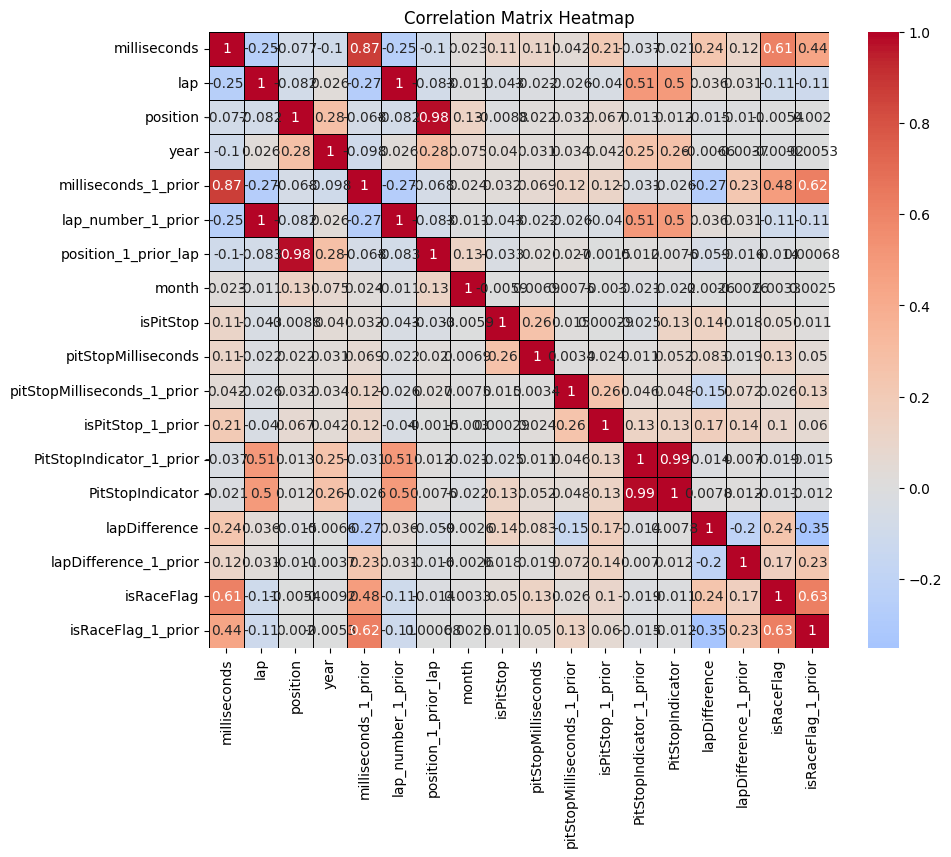

In [28]:
columns_for_corr = [
    "milliseconds",
    "lap",
    "position",
    "year",
    "milliseconds_1_prior",
    "lap_number_1_prior",
    "position_1_prior_lap",
    "month",
    "isPitStop",
    "pitStopMilliseconds",
    "pitStopMilliseconds_1_prior",
    "isPitStop_1_prior",
    "PitStopIndicator_1_prior",
    "PitStopIndicator",
    "lapDifference",
    "lapDifference_1_prior",
    "isRaceFlag",
    "isRaceFlag_1_prior",
]

engineered_lap_times_df_corr_matrix = engineered_lap_times_df[columns_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    engineered_lap_times_df_corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor="black",
)
plt.title("Correlation Matrix Heatmap")
plt.show()

##### select features for training

In [29]:
# drop columns to avoid data leak
engineered_lap_times_df = engineered_lap_times_df.drop(
    columns=config.get("DROP_COLUMNS_AVOID_LEAKAGE")
)
engineered_lap_times_df = engineered_lap_times_df.drop(
    columns=config.get("DROP_COLUMNS_CORR")
)
engineered_lap_times_df.columns

Index(['raceId', 'lap', 'milliseconds', 'year', 'milliseconds_1_prior',
       'position_1_prior_lap', 'isPitStop_1_prior', 'lapDifference_1_prior',
       'isRaceFlag_1_prior', 'circuitId_1', 'circuitId_2', 'circuitId_3',
       'circuitId_4', 'circuitId_5', 'circuitId_6', 'circuitId_7',
       'circuitId_8', 'circuitId_9', 'circuitId_10', 'circuitId_11',
       'circuitId_12', 'circuitId_13', 'circuitId_14', 'circuitId_15',
       'circuitId_16', 'circuitId_17', 'circuitId_18', 'circuitId_19',
       'circuitId_20', 'circuitId_21', 'circuitId_22', 'circuitId_24',
       'circuitId_32', 'circuitId_34', 'circuitId_35', 'circuitId_39',
       'circuitId_68', 'circuitId_69', 'circuitId_70', 'circuitId_71',
       'circuitId_73', 'circuitId_75', 'circuitId_76', 'circuitId_77',
       'circuitId_78', 'circuitId_79'],
      dtype='object')

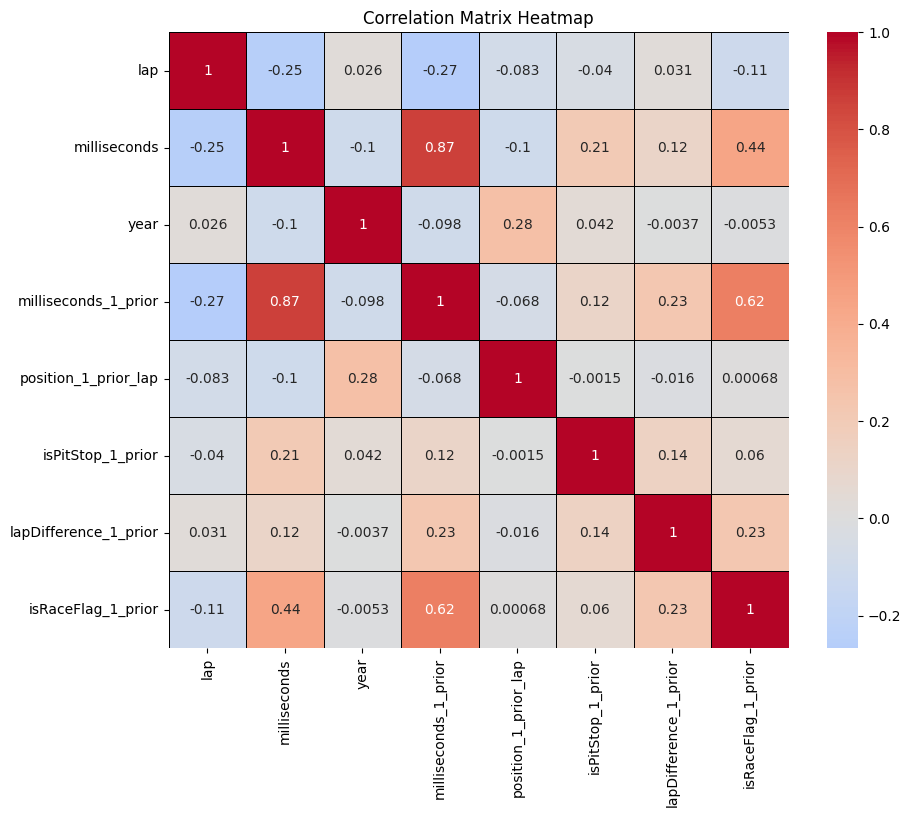

In [30]:
columns_for_corr = [
    "lap",
    "milliseconds",
    "year",
    "milliseconds_1_prior",
    "position_1_prior_lap",
    "isPitStop_1_prior",
    "lapDifference_1_prior",
    "isRaceFlag_1_prior",
]

engineered_lap_times_df_corr_matrix = engineered_lap_times_df[columns_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    engineered_lap_times_df_corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor="black",
)
plt.title("Correlation Matrix Heatmap")
plt.show()

## Spliting into train test

 - First a race_id is selected which will act as an unseen set, and the model will perform predictions on it

In [31]:
split_obj = splitData()

train_data, test_data = split_obj.train_test_split(
    data=engineered_lap_times_df, race_id_list=config.get("RACE_ID_TEST_SET")
)

# Transform data for LSTM model
- scaling 
    - Scale each numerical column using appropriate scaler
- sequencing
    - all scaled and categorical columns are combined 
    - the dataframe is then converted to a sequential tensor

In [32]:
data_transform_obj = transformData(
    n_steps_input=config.get("NUMBER_OF_HISTORICAL_LAP"),
    n_steps_output=config.get("N_STEP_OUTPUT"),
    config=config,
)

scaled_input_df_train, scaled_output_df_train = (
    data_transform_obj.create_scaled_input_output_data(data=train_data, train=True)
)

INFO:root:scaler_dict.pkl saved to ../artifacts/


In [33]:
x_sequential_train, y_sequential_train = data_transform_obj.create_sequence(
    scaled_input_df=scaled_input_df_train, scaled_output_df=scaled_output_df_train
)

In [34]:
x_train, x_val, y_train, y_val = split_obj.train_validation_split(
    x_sequential_ls=x_sequential_train, y_sequential_ls=y_sequential_train
)

In [35]:
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)

x_train = torch.reshape(
    x_train,
    (
        x_train.shape[0],
        config.get("NUMBER_OF_HISTORICAL_LAP"),
        x_train.shape[2],
    ),
)

x_validation = torch.Tensor(x_val)
y_validation = torch.Tensor(y_val)

x_validation = torch.reshape(
    x_validation,
    (
        x_validation.shape[0],
        config.get("NUMBER_OF_HISTORICAL_LAP"),
        x_validation.shape[2],
    ),
)

## Model training
- Create data loader for the LSTM model
- define LSTM model architecture
- define training loop
- train and save the model 

In [36]:
train_obj = train(config=config)

train_data_loader, validation_data_loader = train_obj.create_data_loader(
    batch_size=config.get("BATCH_SIZE"),
    x_train=x_train,
    y_train=y_train,
    x_validation=x_validation,
    y_validation=y_validation,
)

In [37]:
x_train.shape

torch.Size([11628, 2, 44])

In [38]:
lstm_model = LSTM(
    num_classes=config.get("N_STEP_OUTPUT"),
    input_size=x_train.shape[2],
    hidden_size_layer_1=config.get("HIDDEN_SIZE_1"),
    hidden_size_layer_2=config.get("HIDDEN_SIZE_2"),
    num_layers=config.get("NUM_LAYERS"),
    dense_layer_size=config.get("DENSE_LAYER"),
    dropout_rate=0.2,
)
lstm_model.to(device)

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

validation_loss_ls, ls_train_loss, model = train_obj.train_validation_loop(
    n_epochs=config.get("N_EPOCHS"),
    lstm_model=lstm_model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_data_loader,
    validation_loader=validation_data_loader,
    device=device,
)
save_as_pickle(path=config.get("MODEL_PATH"), artifact_name="model.pkl", artifact=model)

Epoch num: 0
Average train loss accross batch: 0.39742901966427313
Validation loss: 0.3745420575141907
Epoch num: 1
Average train loss accross batch: 0.37416401039552427
Validation loss: 0.3670426309108734
Epoch num: 2
Average train loss accross batch: 0.36880373639713965
Validation loss: 0.3529764413833618
Epoch num: 3
Average train loss accross batch: 0.3605038989591861
Validation loss: 0.3836139142513275
Epoch num: 4
Average train loss accross batch: 0.366693611100275
Validation loss: 0.3523957431316376
Epoch num: 5
Average train loss accross batch: 0.3618390862688874
Validation loss: 0.3514995276927948
Epoch num: 6
Average train loss accross batch: 0.35434388110706627
Validation loss: 0.3488427400588989
Epoch num: 7
Average train loss accross batch: 0.3564261183265812
Validation loss: 0.3616366982460022
Epoch num: 8
Average train loss accross batch: 0.36460176865588206
Validation loss: 0.3650600016117096
Epoch num: 9
Average train loss accross batch: 0.36291557348258896


INFO:root:model.pkl saved to ../artifacts/


Validation loss: 0.3481326401233673


In [39]:
fig = go.Figure()

loss_df = pd.DataFrame(
    {"validation_loss": validation_loss_ls, "train_loss": ls_train_loss}
)


fig.add_trace(
    go.Scatter(
        x=loss_df.index,
        y=loss_df["validation_loss"],
        mode="lines+markers",
        name="Validation Loss",
    )
)

fig.add_trace(
    go.Scatter(
        x=loss_df.index,
        y=loss_df["train_loss"],
        mode="lines+markers",
        name="Train Loss",
    )
)

fig.update_layout(
    title="Best model Validation and train loss while training",
    xaxis_title="Epochs",
    yaxis_title="loss",
)
fig.show()

## Hyper parameter tuning

- use random tuning technique to find the best model

In [40]:
# hyper paramter tuning

best_validation_loss = 100

for i in range(config.get("NUM_RUNS")):
    param_space = config.get("HYPER_PARAMS")

    random_params = {
        "LEARNING_RATE": random.choice(param_space["LEARNING_RATE"]),
        "BATCH_SIZE": random.choice(param_space["BATCH_SIZE"]),
        "DROPOUT": random.choice(param_space["DROPOUT"]),
        "HIDDEN_SIZE_1": random.choice(param_space["HIDDEN_SIZE_1"]),
        "HIDDEN_SIZE_2": random.choice(param_space["HIDDEN_SIZE_2"]),
    }

    avg_val_loss, avg_train_loss, model, ls_val, ls_train = train_obj.tune_model(
        params=random_params,
        x_train=x_train,
        x_validation=x_validation,
        y_train=y_train,
        y_validation=y_validation,
        device=device,
    )

    if avg_val_loss < best_validation_loss:
        best_validation_loss = avg_val_loss
        best_params = random_params
        best_model = model
        best_model_val_loss = ls_val
        best_model_train_loss = ls_train

print(f"best validation loss: {best_validation_loss}, params: {best_params}")
save_as_pickle(
    path=config.get("MODEL_PATH"), artifact_name="best_model.pkl", artifact=best_model
)

Epoch num: 0
Average train loss accross batch: 0.45523372319201133
Validation loss: 0.39347973465919495
Epoch num: 1
Average train loss accross batch: 0.408196809196193
Validation loss: 0.3828681707382202
Epoch num: 2
Average train loss accross batch: 0.3946380780768624
Validation loss: 0.38002312183380127
Epoch num: 3
Average train loss accross batch: 0.3879620403502927
Validation loss: 0.3755894899368286
Epoch num: 4
Average train loss accross batch: 0.38170729047995955
Validation loss: 0.35428255796432495
Epoch num: 5
Average train loss accross batch: 0.34564451055380596
Validation loss: 0.3301528990268707
Epoch num: 6
Average train loss accross batch: 0.338155762531048
Validation loss: 0.3309681713581085
Epoch num: 7
Average train loss accross batch: 0.33409481123602913
Validation loss: 0.3327701985836029
Epoch num: 8
Average train loss accross batch: 0.33104723021798554
Validation loss: 0.32758834958076477
Epoch num: 9
Average train loss accross batch: 0.3303731186648949
Validatio

INFO:root:best_model.pkl saved to ../artifacts/


Average train loss accross batch: 0.3380372180958479
Validation loss: 0.33350899815559387
best validation loss: 0.34028077125549316, params: {'LEARNING_RATE': 0.01, 'BATCH_SIZE': 64, 'DROPOUT': 0.3, 'HIDDEN_SIZE_1': 16, 'HIDDEN_SIZE_2': 32}


In [41]:
fig = go.Figure()

loss_df = pd.DataFrame(
    {"validation_loss": best_model_val_loss, "train_loss": best_model_train_loss}
)


fig.add_trace(
    go.Scatter(
        x=loss_df.index,
        y=loss_df["validation_loss"],
        mode="lines+markers",
        name="Validation Loss",
    )
)

fig.add_trace(
    go.Scatter(
        x=loss_df.index,
        y=loss_df["train_loss"],
        mode="lines+markers",
        name="Train Loss",
    )
)

fig.update_layout(
    title="Best model Validation and train loss while training",
    xaxis_title="Epochs",
    yaxis_title="loss",
)
fig.show()

## Evaluation

- Check model performance in real life setting
- Compare with laptimes from the unseen race id selected earlier
- show the model performance throughout the race

In [42]:
test_selected_race_id = config.get("RACE_ID_TEST_SET")[0]

data_for_eval = test_data[test_data["raceId"] == test_selected_race_id]

gp_name = races_df[races_df["raceId"] == test_selected_race_id]["name"].unique()[0]

print(f"Evaluation for Race Id: {test_selected_race_id}, grand prix name: {gp_name}")

Evaluation for Race Id: 4, grand prix name: Bahrain Grand Prix


In [43]:
infer_obj = makeInference(config=config)

prediction_tensor, actual_sequential, lap_sequential = infer_obj.perform_inference(
    test_data=data_for_eval, device=device
)

tensor([[0.4916, 0.5197, 0.5170, 0.5433, 0.5437],
        [0.2886, 0.3108, 0.3183, 0.3463, 0.3504],
        [0.3484, 0.3710, 0.3754, 0.4024, 0.4056],
        [0.3583, 0.3797, 0.3835, 0.4099, 0.4132],
        [0.3776, 0.4009, 0.4058, 0.4335, 0.4364],
        [0.3523, 0.3745, 0.3796, 0.4069, 0.4102],
        [0.3583, 0.3805, 0.3856, 0.4129, 0.4161],
        [0.3555, 0.3780, 0.3837, 0.4115, 0.4147],
        [0.3912, 0.4132, 0.4163, 0.4427, 0.4456],
        [0.4045, 0.4284, 0.4328, 0.4607, 0.4633],
        [0.3308, 0.3542, 0.3612, 0.3898, 0.3932],
        [0.2884, 0.3099, 0.3184, 0.3466, 0.3509],
        [0.3118, 0.3344, 0.3434, 0.3725, 0.3765],
        [0.3005, 0.3227, 0.3321, 0.3612, 0.3655],
        [0.2914, 0.3136, 0.3235, 0.3527, 0.3572],
        [0.2999, 0.3219, 0.3319, 0.3612, 0.3657],
        [0.3104, 0.3333, 0.3435, 0.3734, 0.3778],
        [0.4449, 0.4649, 0.4622, 0.4853, 0.4879],
        [0.6051, 0.5855, 0.5566, 0.5563, 0.5452],
        [0.8263, 0.8628, 0.8474, 0.8729, 0.8674],


In [44]:
evaluate = evaluateModellingResults()

rmse_mae_mape_dict = evaluate.get_model_evaluation_metrics(
    ls_prediction=prediction_tensor.tolist(),
    ls_actual=actual_sequential,
    lap_sequential=lap_sequential,
)

[103056.6629107073, 103662.63812661171, 103604.48126636446, 104172.07423903048, 104179.14683257043]
[98681.91120418906, 99160.93811879307, 99322.71502547711, 99925.33506260812, 100014.54017175734]
[99971.97166220099, 100457.84766303003, 100553.25253111869, 101134.57193578035, 101203.29337023199]
[100185.4905122891, 100645.48654974252, 100728.40005642921, 101296.07523868233, 101366.695200786]
[100600.7285676673, 101103.55130416155, 101207.37430551648, 101804.85752797872, 101867.10624197125]
[100055.28722514957, 100533.43488252908, 100644.11146594584, 101232.07443286479, 101302.95515350252]
[100185.36591338366, 100662.98306202143, 100772.58257139474, 101360.92447312921, 101431.08007951826]
[100123.58283963054, 100610.2424005866, 100732.75202644616, 101330.75419692695, 101400.87447888404]
[100894.22064717859, 101368.35801813751, 101433.98567461222, 102003.42194036394, 102065.27309393138]
[101180.87006308883, 101695.35821153969, 101789.61407219619, 102390.76461295784, 102447.18094210327]
[

In [45]:
rmse_mae_mape_df = pd.DataFrame(rmse_mae_mape_dict)

In [46]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=rmse_mae_mape_df["current_lap"],
        y=rmse_mae_mape_df["RMSE"],
        mode="lines+markers",
        name=f"RMSE",
    )
)

fig.add_trace(
    go.Scatter(
        x=rmse_mae_mape_df["current_lap"],
        y=rmse_mae_mape_df["MAE"],
        mode="lines+markers",
        name=f"MAE",
    )
)


fig.update_layout(
    title="error rate in prediction at each lap",
    xaxis_title="Lap number",
    yaxis_title="Error",
)

In [47]:
test_selected_race_id = config.get("RACE_ID_TEST_SET")[1]

data_for_eval = test_data[test_data["raceId"] == test_selected_race_id]

gp_name = races_df[races_df["raceId"] == test_selected_race_id]["name"].unique()[0]

print(f"Evaluation for Race Id: {test_selected_race_id}, granf prix name: {gp_name}")

Evaluation for Race Id: 17, granf prix name: Abu Dhabi Grand Prix


In [48]:
infer_obj = makeInference(config=config)

prediction_tensor, actual_sequential, lap_sequential = infer_obj.perform_inference(
    test_data=data_for_eval, device=device
)

tensor([[0.6289, 0.6592, 0.6530, 0.6793, 0.6784],
        [0.5540, 0.5759, 0.5628, 0.5817, 0.5820],
        [0.5539, 0.5753, 0.5640, 0.5837, 0.5842],
        [0.5475, 0.5703, 0.5606, 0.5816, 0.5821],
        [0.5242, 0.5448, 0.5353, 0.5555, 0.5565],
        [0.5081, 0.5300, 0.5234, 0.5455, 0.5467],
        [0.5028, 0.5232, 0.5158, 0.5370, 0.5383],
        [0.4936, 0.5154, 0.5105, 0.5334, 0.5348],
        [0.4850, 0.5058, 0.5004, 0.5226, 0.5242],
        [0.4840, 0.5049, 0.5000, 0.5225, 0.5240],
        [0.5001, 0.5216, 0.5162, 0.5387, 0.5401],
        [0.4782, 0.5003, 0.4972, 0.5211, 0.5227],
        [0.4820, 0.5025, 0.4971, 0.5191, 0.5208],
        [0.4524, 0.4738, 0.4714, 0.4952, 0.4972],
        [0.4334, 0.4525, 0.4492, 0.4716, 0.4739],
        [0.4459, 0.4655, 0.4625, 0.4853, 0.4875],
        [0.4118, 0.4326, 0.4335, 0.4585, 0.4612],
        [0.5905, 0.6075, 0.5906, 0.6065, 0.6055],
        [1.0523, 0.9390, 0.8518, 0.7989, 0.7546],
        [0.9807, 1.0221, 1.0104, 1.0404, 1.0352],


In [49]:
evaluate = evaluateModellingResults()

rmse_mae_mape_dict = evaluate.get_model_evaluation_metrics(
    ls_prediction=prediction_tensor.tolist(),
    ls_actual=actual_sequential,
    lap_sequential=lap_sequential,
)

[106016.86636516452, 106668.77811464667, 106535.20423443615, 107101.45102511346, 107083.64622688293]
[104402.20199476182, 104874.59626556933, 104591.57563221455, 104999.7346714288, 105005.56384496391]
[104400.43448863924, 104861.09976351261, 104616.7959921062, 105042.22675175965, 105053.72324870527]
[104263.07511384785, 104752.56769424677, 104543.44320349395, 104997.21058019996, 105007.53173695505]
[103760.34807445109, 104202.81548650563, 103998.63256265223, 104434.56688158214, 104455.98376354575]
[103413.82567316294, 103885.43124574423, 103742.8361478746, 104219.76222217083, 104244.03974086046]
[103298.35588546097, 103738.1900216788, 103578.85628116131, 104034.7135797143, 104062.934589535]
[103101.31042364985, 103570.45420445502, 103465.22978654504, 103959.09360483289, 103989.08725887537]
[102915.14231783152, 103363.42092007399, 103246.87470059097, 103725.8020645231, 103759.15218186378]
[102894.37668994069, 103345.0213868618, 103237.71154294163, 103722.33641661704, 103756.1874986291]


In [50]:
rmse_mae_mape_df = pd.DataFrame(rmse_mae_mape_dict)

In [51]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=rmse_mae_mape_df["current_lap"],
        y=rmse_mae_mape_df["RMSE"],
        mode="lines+markers",
        name=f"RMSE",
    )
)

fig.add_trace(
    go.Scatter(
        x=rmse_mae_mape_df["current_lap"],
        y=rmse_mae_mape_df["MAE"],
        mode="lines+markers",
        name=f"MAE",
    )
)


fig.update_layout(
    title="error rate in prediction at each lap",
    xaxis_title="Lap number",
    yaxis_title="Error",
)

In [52]:
test_selected_race_id = config.get("RACE_ID_TEST_SET")[2]

data_for_eval = test_data[test_data["raceId"] == test_selected_race_id]

gp_name = races_df[races_df["raceId"] == test_selected_race_id]["name"].unique()[0]

print(f"Evaluation for Race Id: {test_selected_race_id}, granf prix name: {gp_name}")

Evaluation for Race Id: 5, granf prix name: Spanish Grand Prix


In [53]:
infer_obj = makeInference(config=config)

prediction_tensor, actual_sequential, lap_sequential = infer_obj.perform_inference(
    test_data=data_for_eval, device=device
)

tensor([[1.0629, 0.6631, 0.4739, 0.2852, 0.1833],
        [1.4087, 0.7755, 0.4748, 0.1644, 0.0020],
        [0.6778, 0.1984, 0.0613, 0.0000, 0.0000],
        [0.4032, 0.2550, 0.1932, 0.1372, 0.1034],
        [0.2951, 0.3220, 0.3101, 0.3318, 0.3256],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0185],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],


In [54]:
evaluate = evaluateModellingResults()

rmse_mae_mape_dict = evaluate.get_model_evaluation_metrics(
    ls_prediction=prediction_tensor.tolist(),
    ls_actual=actual_sequential,
    lap_sequential=lap_sequential,
)

[115369.18313631415, 106752.64216968417, 102676.89957668632, 98610.23728948832, 96413.64175948873]
[122821.3434779942, 109174.62266872823, 102694.36012227088, 96006.12273475528, 92506.98594252998]
[107070.54921203852, 96738.03404641896, 93783.53211584501, 92463.0, 92463.0]
[101151.2335069403, 97957.9742224738, 96627.6053762883, 95419.59811447933, 94690.39377826266]
[98822.94753121585, 99402.750554353, 99145.46087949723, 99612.78384640068, 99478.99930412322]
[92463.0, 92463.0, 92463.0, 92463.0, 92862.725250802]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463.0, 92463.0, 92463.0]
[92463.0, 92463.0, 92463

In [55]:
rmse_mae_mape_df = pd.DataFrame(rmse_mae_mape_dict)

In [56]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=rmse_mae_mape_df["current_lap"],
        y=rmse_mae_mape_df["RMSE"],
        mode="lines+markers",
        name=f"RMSE",
    )
)

fig.add_trace(
    go.Scatter(
        x=rmse_mae_mape_df["current_lap"],
        y=rmse_mae_mape_df["MAE"],
        mode="lines+markers",
        name=f"MAE",
    )
)


fig.update_layout(
    title="error rate in prediction at each lap",
    xaxis_title="Lap number",
    yaxis_title="Error",
)